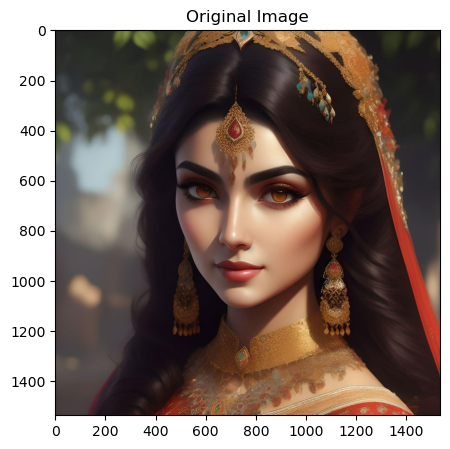

In [10]:
import cv2
import sys
import dlib
import numpy as np
from matplotlib import pyplot as plt

# Define our imshow function 
def imshow(title = "Image", image = None, size = 5):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

# Load & Show our input image
image = cv2.imread('fotor-ai-2023062074316.jpg')
imshow("Original Image", image)

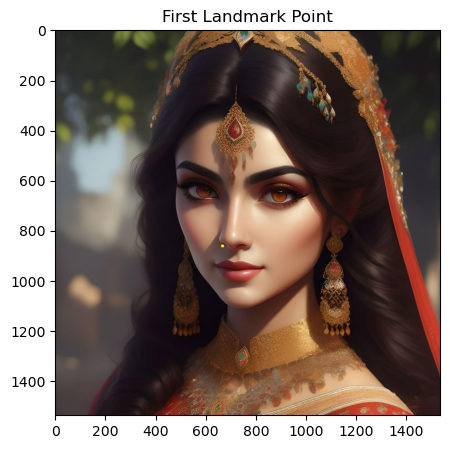

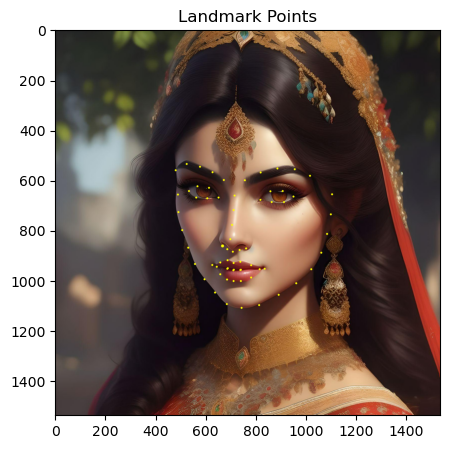

In [11]:
# Grayscale
gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Initialize dlib's face detector
detector = dlib.get_frontal_face_detector()

# Detecting faces in the grayscale image
faces = detector(gray)

# Creating a for loop in order to extract
# specific coordinates (x1,x2,y1,y2)
for face in faces:
  x1=face.left()
  y1=face.top()
  x2=face.right()
  y2=face.bottom()

p = "shape_predictor_68_face_landmarks.dat"
# Initialize dlib's shape predictor
predictor = dlib.shape_predictor(p)

# Get the shape using the predictor
landmarks=predictor(gray, face)

# Defining x and y coordinates of a specific point
x=landmarks.part(31).x
y=landmarks.part(31).y

# Drawing a circle
copy = image.copy()
cv2.circle(copy, (x, y), 6, (0, 255, 255), -1)
imshow("First Landmark Point", copy)

for n in range(0,68):
    x=landmarks.part(n).x
    y=landmarks.part(n).y
    cv2.circle(copy, (x, y), 4, (0, 255, 255), -1)
    
imshow("Landmark Points", copy)


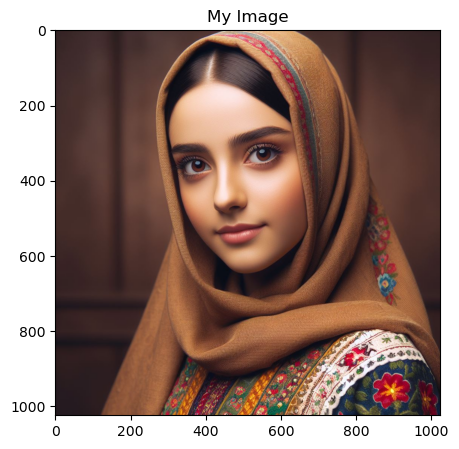

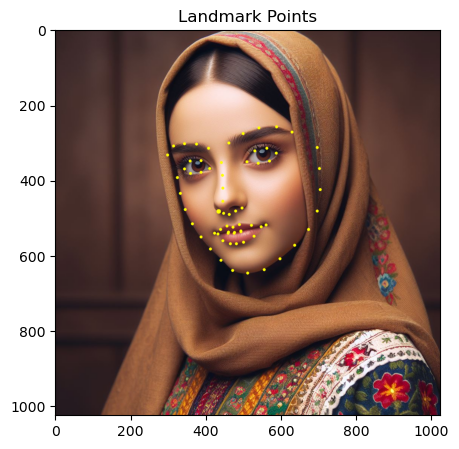

In [13]:
# Load & Show our input image
img = cv2.imread('2nd.jpeg')
imshow("My Image", img)

# Grayscale
gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detecting faces in the grayscale image
faces = detector(gray)

# Creating a for loop in order to extract
# specific coordinates (x1,x2,y1,y2)
for face in faces:
  x1=face.left()
  y1=face.top()
  x2=face.right()
  y2=face.bottom()

# Get the shape using the predictor
landmarks=predictor(gray, face)

# Defining x and y coordinates of a specific point
x=landmarks.part(31).x
y=landmarks.part(31).y

# Drawing a circle
copy2 = img.copy()
cv2.circle(copy2, (x, y), 6, (0, 255, 255), -1)

for n in range(0,68):
    x=landmarks.part(n).x
    y=landmarks.part(n).y
    cv2.circle(copy2, (x, y), 4, (0, 255, 255), -1)
    
imshow("Landmark Points", copy2)

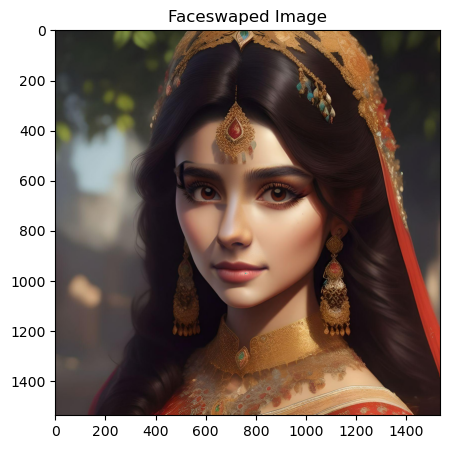

In [14]:
# Define range of feature points according to their feature
FACE_POINTS = list(range(17, 68))
MOUTH_POINTS = list(range(48, 61))
RIGHT_BROW_POINTS = list(range(17, 22))
LEFT_BROW_POINTS = list(range(22, 27))
RIGHT_EYE_POINTS = list(range(36, 42))
LEFT_EYE_POINTS = list(range(42, 48))
NOSE_POINTS = list(range(27, 35))
JAW_POINTS = list(range(0, 17))

# Points used to line up the images.
ALIGN_POINTS = (LEFT_BROW_POINTS + RIGHT_EYE_POINTS + LEFT_EYE_POINTS + RIGHT_BROW_POINTS + NOSE_POINTS + MOUTH_POINTS)

# Points from the second image to overlay on the first. The convex hull of each element will be overlaid.
OVERLAY_POINTS = [ LEFT_EYE_POINTS + RIGHT_EYE_POINTS + LEFT_BROW_POINTS + RIGHT_BROW_POINTS, NOSE_POINTS + MOUTH_POINTS, ]

# Obtain facial landmark from the image
def get_landmarks(im):
    rects = detector(im, 1)
    return np.matrix([[p.x, p.y] for p in predictor(im, rects[0]).parts()])

# This function will draw convex hull
def draw_convex_hull(im, points, color):
    points = cv2.convexHull(points)
    cv2.fillConvexPoly(im, points, color=color)


# Obain face mask of image using landmarks
def get_face_mask(im, landmarks):
    im = np.zeros(im.shape[:2], dtype=np.float64)
    for group in OVERLAY_POINTS:
        draw_convex_hull(im, landmarks[group],color=1)
    im = np.array([im, im, im]).transpose((1, 2, 0))
    im = (cv2.GaussianBlur(im, (11, 11), 0) > 0) * 1.0
    im = cv2.GaussianBlur(im, (11, 11), 0)
    return im


# Perform affine transformation and return it
def transformation_from_points( points1, points2):
    points1 = points1.astype(np.float64)
    points2 = points2.astype(np.float64)
    c1 = np.mean(points1, axis=0)
    c2 = np.mean(points2, axis=0)
    points1 -= c1
    points2 -= c2
    s1 = np.std(points1)
    s2 = np.std(points2)
    points1 /= s1
    points2 /= s2
    U, S, Vt = np.linalg.svd(points1.T * points2)
    # The R we seek is in fact the transpose of the one given by U * Vt. This is because the above formulation assumes the matrix goes on the right (with row vectors) where as our solution requires the matrix to be on the left (with column vectors).
    R = (U * Vt).T
    return np.vstack([ np.hstack(((s2 / s1) * R, c2.T - (s2 / s1) * R * c1.T)), np.matrix([0., 0., 1.])])


# This function resize image and obtain landmark by giving our image as parameter
def resize_and_landmarks(img):
    im = cv2.resize(img, (img.shape[1], img.shape[0]))
    lands = get_landmarks(img)
    return im, lands

# Wrap feature of im with M
def warp_im(im, M, dshape):
    output_im = np.zeros(dshape, dtype=im.dtype)
    cv2.warpAffine(im, M[:2], (dshape[1], dshape[0]), dst=output_im, borderMode= cv2.BORDER_TRANSPARENT, flags= cv2.WARP_INVERSE_MAP)
    return output_im


# Adjuct color properly so image will look more real
def correct_colours(im1, im2, landmarks1):
    blur_amount = 0.6 * np.linalg.norm( np.mean( landmarks1[ LEFT_EYE_POINTS], axis=0) - np.mean(landmarks1[ RIGHT_EYE_POINTS], axis=0))
    blur_amount = int(blur_amount)
    if blur_amount % 2 == 0:
        blur_amount += 1
    im1_blur = cv2.GaussianBlur(im1, (blur_amount, blur_amount), 0)
    im2_blur = cv2.GaussianBlur(im2, (blur_amount, blur_amount), 0)
    # Avoid divide-by-zero errors.
    im2_blur += (128 * (im2_blur <= 1.0)).astype(im2_blur.dtype)
    return (im2.astype(np.float64) * im1_blur.astype(np.float64) / im2_blur.astype(np.float64))

# Obtain landmarks along with image.
im1, landmarks1 = resize_and_landmarks(image)
im2, landmarks2 = resize_and_landmarks(img)

# Normalize points
M = transformation_from_points( landmarks1[ALIGN_POINTS], landmarks2[ALIGN_POINTS])

# Creat mask and wrap features
mask = get_face_mask(im2, landmarks2)
warped_mask = warp_im(mask, M, im1.shape)
combined_mask = np.max([get_face_mask(im1, landmarks1), warped_mask],axis=0)

# Apply masking to target image
warped_im2 = warp_im(im2, M, im1.shape)
warped_corrected_im2 = correct_colours(im1, warped_im2, landmarks1)

# Normalize output image
output = im1 * (1.0 - combined_mask) + warped_corrected_im2 * combined_mask

# Show faceswapped image
imshow("Faceswaped Image", output.astype(np.uint8))